<a href="https://colab.research.google.com/github/dudesparsh/Applied-ML/blob/master/Regression_with_BIWI_head_pose.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Our aim here is to find the center of the head

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *

In [0]:
# Getting and converting the data - preparing
path = untar_data(URLs.BIWI_HEAD_POSE)

In [16]:
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6); cal

array([[517.679,   0.   , 320.   ],
       [  0.   , 517.679, 240.5  ],
       [  0.   ,   0.   ,   1.   ]])

In [0]:
fname = '09/frame_00667_rgb.jpg'

In [0]:
def img2txt_name(f): return path/f'{str(f)[:-7]}pose.txt'

In [0]:
path.ls()

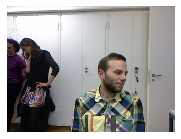

In [20]:
img = open_image(path/fname)
img.show()

## https://nbviewer.jupyter.org/github/fastai/course-v3/blob/master/nbs/dl1/lesson3-head-pose.ipynb

In [21]:
ctr = np.genfromtxt(img2txt_name(fname), skip_header=3); ctr

array([187.332 ,  40.3892, 893.135 ])

In [0]:
def convert_biwi(coords):
    c1 = coords[0] * cal[0][0]/coords[2] + cal[0][2]
    c2 = coords[1] * cal[1][1]/coords[2] + cal[1][2]
    return tensor([c2,c1])

def get_ctr(f):
    ctr = np.genfromtxt(img2txt_name(f), skip_header=3)
    return convert_biwi(ctr)

def get_ip(img,pts): return ImagePoints(FlowField(img.size, pts), scale=True)


In [30]:
get_ctr(fname)

tensor([263.9104, 428.5814])

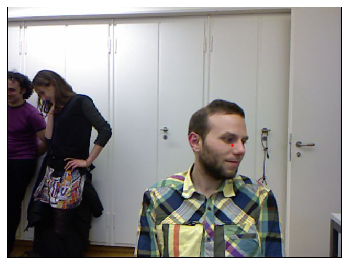

In [31]:
ctr = get_ctr(fname)
img.show(y=get_ip(img, ctr), figsize=(6, 6))


In [0]:
## Creating a dataset
data = (PointsItemList.from_folder(path)
        .split_by_valid_func(lambda o: o.parent.name=='13')
        .label_from_func(get_ctr)
        .transform(get_transforms(), tfm_y=True, size=(120,160))
        .databunch().normalize(imagenet_stats)
       )


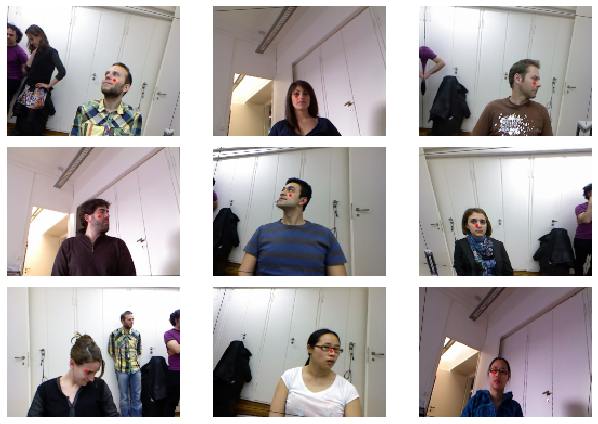

In [33]:
data.show_batch(3, figsize =(9,6))

In [35]:
## Training the model
learn = cnn_learner(data, models.resnet34)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 65.9MB/s]


epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


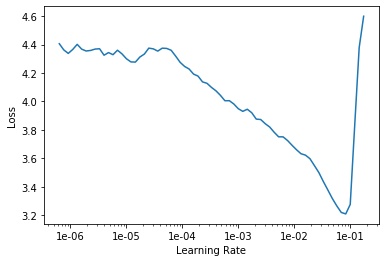

In [36]:
learn.lr_find()
learn.recorder.plot()

In [0]:
lr = 2e-2

In [38]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,time
0,0.120801,0.072386,02:51
1,0.042009,0.005833,02:51
2,0.014585,0.003203,02:51
3,0.008717,0.001696,02:51
4,0.006472,0.001239,02:53


In [0]:
learn.save('stage-1')

In [40]:
learn.load('stage-1')

Learner(data=ImageDataBunch;

Train: LabelList (15193 items)
x: PointsItemList
Image (3, 120, 160),Image (3, 120, 160),Image (3, 120, 160),Image (3, 120, 160),Image (3, 120, 160)
y: PointsLabelList
ImagePoints (120, 160),ImagePoints (120, 160),ImagePoints (120, 160),ImagePoints (120, 160),ImagePoints (120, 160)
Path: /root/.fastai/data/biwi_head_pose;

Valid: LabelList (485 items)
x: PointsItemList
Image (3, 120, 160),Image (3, 120, 160),Image (3, 120, 160),Image (3, 120, 160),Image (3, 120, 160)
y: PointsLabelList
ImagePoints (120, 160),ImagePoints (120, 160),ImagePoints (120, 160),ImagePoints (120, 160),ImagePoints (120, 160)
Path: /root/.fastai/data/biwi_head_pose;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, cei

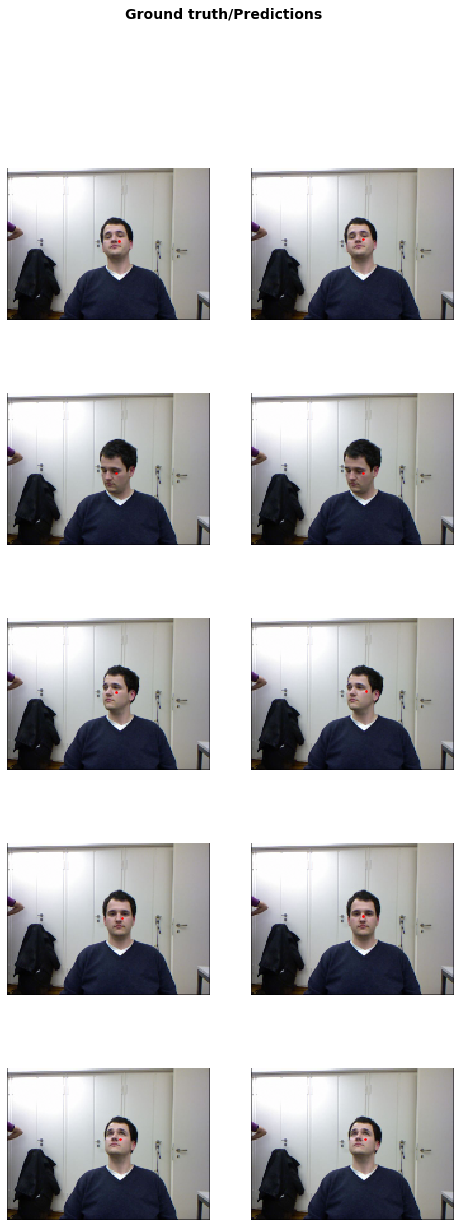

In [41]:
learn.show_results()

In [0]:
## Data augmentation
tfms = get_transforms(max_rotate=20, max_zoom=1.5, max_lighting=0.5, max_warp=0.4, p_affine=1., p_lighting=1.)

data = (PointsItemList.from_folder(path)
        .split_by_valid_func(lambda o: o.parent.name=='13')
        .label_from_func(get_ctr)
        .transform(tfms, tfm_y=True, size=(120,160))
        .databunch().normalize(imagenet_stats)
       )


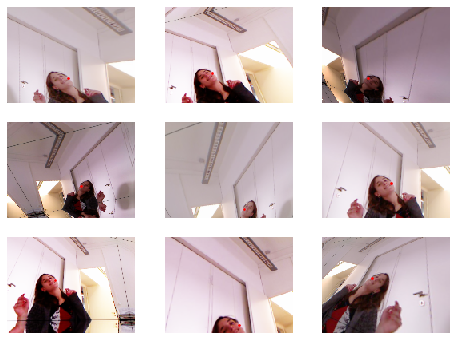

In [43]:
def _plot(i,j,ax):
    x,y = data.train_ds[0]
    x.show(ax, y=y)

plot_multi(_plot, 3, 3, figsize=(8,6))
